# AUCMEDI Example

## Regular pipeline

This sample notebook gives you an impression on how to apply *AUCMEDI* to any common image classification task in the field of medical imaging. We provide step-by-step explanations to help you understand, what's happening.


### Step 1: Setup

Setting up GPU

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

### Step 2: Imports

Besides the *AUCMEDI* library, we use `os` to manage file paths, and `csv` to handle CSV files. To add callbacks to our model, we also work with `tensorflow` directly. For XAI in step 18, we need to be able to generate some simple random numbers, using `random`. We're storing our XAI related predictions using `pandas`.

In [2]:
from aucmedi import *
import csv
import tensorflow as tf
import random
import pandas as pd

***

### Step 3: Constants

For convenience, we define the constant values we need along the way here.

In [3]:
# Seed for replicability of random actions
seed = 341

# Is the classification task a multi-label problem?
is_multilabel = False
activation_function = 'sigmoid' if is_multilabel else 'softmax'

# CSV: Are the labels one-hot-encoded?
is_ohe = True

# Epochs to train
epochs = 500

# Splits
splits = [0.7, 0.1, 0.2]

# Label that impacts the output path
iteration_index = '07'
project_name = 'ct-covid'
iteration_label = '{}_{}'.format(iteration_index, project_name)

# Interface type
type_of_annotations = 'directory'

# CSV: Identifying column within our interface
col_id = 'image'
csv_newline = ''

# Paths
path_input = os.path.join('assets', 'sample', project_name)
path_snapshot = os.path.join('assets', iteration_label, 'out', 'snapshots')
path_snapshot_file = os.path.join('assets', iteration_label, 'out', 'snapshots', 'model.h5')
path_history = os.path.join('assets', iteration_label, 'out', 'history')
path_images = os.path.join('assets', iteration_label, 'out', 'img')
path_class_distribution = os.path.join('assets', iteration_label, 'info')
path_xai = os.path.join('assets', iteration_label, 'out', 'xai')
path_xai_predictions = os.path.join(path_xai, 'predictions.csv')

# CSV: Path to ground truth
path_truth = os.path.join('assets', 'sample', project_name, 'ground_truth.csv')

# Model specifics
architecture_name = '2D.DenseNet121'
nn_metrics = ['categorical_accuracy']
use_pretrained = True
callbacks = []

***

### Step 4: Create output directories

To avoid mistakes, we want to make sure that the training-specific output paths are generated anew.

In [4]:
os.makedirs(path_snapshot, exist_ok=False)
os.makedirs(path_images, exist_ok=False)
os.makedirs(path_class_distribution, exist_ok=False)

***

### Step 5: Read ground truth

To find all available classes, we need to distinguish if we have a `CSV` based annotation or if we're using directories.

#### Step 5.1: CSV

With a CSV-based interface, we can read the labels from the ground truth file.

#### Step 5.2: Directory

When using directories, we simply need to read the labels of all sub-directories.


In [5]:
valid_classes = None

def handle_csv():
    with open(path_truth, newline=csv_newline) as file:
        reader = csv.reader(file)
        first_row = next(reader)
        
        # Since the ISIC training data set does not contain any samples for 'UNK', we eliminate the class for our purposes
        if project_name == 'dermatoscopy': 
            return [th for th in first_row if th != col_id and th != 'UNK']
        else: 
            return first_row[1:]

annotation_handler = {
    'csv': handle_csv
}

try:
    valid_classes = annotation_handler[type_of_annotations]()
    print('Valid classes have been successfully set!')
    print(valid_classes)
except KeyError:
    print('Cannot handle annotation type {}'.format(type_of_annotations))


Cannot handle annotation type directory


***

### Step 6: Load data

By calling `input_interface()`, we can load all the information we need about a data set.

In [6]:
if type_of_annotations == 'csv':
    ds_loader = input_interface(
        interface=type_of_annotations, # Type of annotations
        path_imagedir=path_input, # Path to images
        col_sample=col_id, # Name of the column that identifies an image
        path_data=path_truth, # Path to labels
        ohe=is_ohe, # Are labels one-hot-encoded?
        ohe_range=valid_classes # Possible values
    )
elif type_of_annotations == 'directory':
    ds_loader = input_interface(
        interface=type_of_annotations,
        path_imagedir=path_input
    )

(index_list, labels_ohe, n_classes, class_names, image_format) = ds_loader

***

### Step 7: Class distribution

To plot the class distribution, we can use *AUCMEDI*'s [evaluate functionality](https://frankkramer-lab.github.io/aucmedi/reference/evaluation/dataset/#aucmedi.evaluation.dataset.evaluate_dataset). 

In [7]:
from aucmedi.evaluation import *

evaluate_dataset(
    samples=index_list,
    labels=labels_ohe,
    out_path=path_class_distribution,
    class_names=class_names,
    plot_barplot=True
)

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: assets/07_ct-covid/info/plot.dataset.barplot.png


,class,class_freq,class_perc
0,NiCT,5705,29.0
1,nCT,9979,51.0
2,pCT,4001,20.0


***

### Step 8: Split data set

For our case, we are splitting our set of images into three data sets, `set_train`, `set_val` and `set_test` respectively.

In [8]:
from aucmedi.sampling.split import sampling_split

set_train, set_val, set_test = sampling_split(
    samples=index_list, # list of sample names
    labels=labels_ohe, # list of corresponding labels
    sampling=splits, # percentage splits
    stratified=True, # Allow overlaps between sets
    iterative=is_multilabel, # Approximation of a solution is only useful for multi label problems
    seed=seed # Seed for replicability of random actions
)

***

### Step 9: Prepare model

In preparation for a robust classificator, we plan on using common utilities, like image augmentation and several callbacks.

#### 9.1: Image Augmentation

By default, the `Image_Augmentation` object applies

- Flipping
- Rotation
- Changes to brightness
- Changes to contrast
- Changes to saturation
- Changes to hue
- Changes to scale


In [9]:
from aucmedi.data_processing import augmentation

data_aug = augmentation.ImageAugmentation()

***

#### 9.2 Callback: Early Stopping

When we see none, or very small improvements in performance, we abort training to save resources.

#### 9.3: Callback: Dynamic Learning Rate

Reducing the learning rate, is often beneficial to models, when improvements are beginning to stagnate.

#### 9.4: Callback: CSV Logger

We intend to persist the histories that our training generates for further analysis.

#### 9.5: Callback: Checkpoint

To persist our model, we use the callback ModelCheckpoint.


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, ModelCheckpoint

# 9.2 Early Stopping
cb_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=12,
    verbose=1,
)

callbacks.append(cb_early_stopping)

# 9.3 Dynamic learning rate
cb_reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='min',
    min_lr=1e-7
)

callbacks.append(cb_reduce_learning_rate)

# 9.4 CSV Logger
cb_csv_logger = CSVLogger(
    filename=path_history,
    separator=',',
    append=True
)

callbacks.append(cb_csv_logger)

# 9.5 Model Checkpoint
cb_model_checkpoint = ModelCheckpoint(
    filepath=path_snapshot_file,
    monitor='val_loss',
    save_best_only=True
)

callbacks.append(cb_model_checkpoint)

***

### Step 10: Model

Before we can build our model, we need to instantiate the class weights and loss function. Please note: Multilabel problems have to be handled explicitly, because their classes potentially overlap.

In [11]:
from aucmedi.utils.class_weights import compute_class_weights, compute_multilabel_weights
from aucmedi.neural_network.loss_functions import *
from aucmedi.neural_network import model

# Loss
if is_multilabel:
    class_weights = compute_multilabel_weights(set_train[1])
    loss = multilabel_focal_loss(class_weights)
else: 
    cw_loss, class_weights = compute_class_weights(set_train[1])
    loss = categorical_focal_loss(cw_loss)

model = model.NeuralNetwork(
    n_labels=n_classes,
    channels=3,
    architecture=architecture_name,
    pretrained_weights=use_pretrained,
    loss=loss, # Categorical focal loss for both multiclass and binary problems
    metrics=nn_metrics,
    activation_output=activation_function # Sigmoid for multilabel problems, else softmax
)

2022-09-28 17:42:17.355698: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 17:42:17.891866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22846 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:40:00.0, compute capability: 7.5


***

### Step 11: Prepare training

Training the model with our `training` and `validation` sets, requires an instance of a `DataGenerator`, each.

In [12]:
from aucmedi.data_processing import data_generator

gen_train = data_generator.DataGenerator(
    samples=set_train[0],
    labels=set_train[1],
    path_imagedir=path_input,
    image_format=image_format,
    data_aug=data_aug,
    resize=model.meta_input, # Applying transfer learning, means that we should not change the model's image size expectations
    standardize_mode=model.meta_standardize, # Same goes for the standardization of values
    seed=seed
)

gen_val = data_generator.DataGenerator(
    samples=set_val[0],
    labels=set_val[1],
    path_imagedir=path_input,
    image_format=image_format,
    data_aug=data_aug,
    resize=model.meta_input, # Applying transfer learning, means that we should not change the model's image size expectations
    standardize_mode=model.meta_standardize, # Same goes for the standardization of values
    seed=seed
)

***

### Step 12: Training

To train a model, we provide the `train()` function with our callbacks and the training and validation generator.


In [13]:
history = model.train(
    training_generator=gen_train,
    validation_generator=gen_val,
    epochs=epochs,
    callbacks=callbacks,
    # class_weights=class_weights, # Applying class weights is incompatible with the focal loss function we define in step 10. 
    transfer_learning=True
)

Epoch 1/10


2022-09-28 17:42:26.176589: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-09-28 17:42:26.706781: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


431/431 [==============================] - 138s 305ms/step - loss: 0.2724 - categorical_accuracy: 0.7700 - val_loss: 0.0971 - val_categorical_accuracy: 0.9060 - lr: 1.0000e-04
Epoch 2/10
431/431 [==============================] - 132s 306ms/step - loss: 0.1249 - categorical_accuracy: 0.8749 - val_loss: 0.0813 - val_categorical_accuracy: 0.9213 - lr: 1.0000e-04
Epoch 3/10
431/431 [==============================] - 131s 303ms/step - loss: 0.1044 - categorical_accuracy: 0.8885 - val_loss: 0.0753 - val_categorical_accuracy: 0.9319 - lr: 1.0000e-04
Epoch 4/10
431/431 [==============================] - 130s 302ms/step - loss: 0.1038 - categorical_accuracy: 0.8901 - val_loss: 0.0640 - val_categorical_accuracy: 0.9264 - lr: 1.0000e-04
Epoch 5/10
431/431 [==============================] - 131s 304ms/step - loss: 0.0936 - categorical_accuracy: 0.8966 - val_loss: 0.0652 - val_categorical_accuracy: 0.9198 - lr: 1.0000e-04
Epoch 6/10
431/431 [==============================] - 129s 300ms/step - loss

***

### Step 13: Prepare prediction

Similar to our training preparations, we also need to create a `DataGenerator` for predicting labels for our test set.


In [14]:
gen_test = data_generator.DataGenerator(
    samples=set_test[0],
    labels=None,
    path_imagedir=path_input,
    image_format=image_format,
    data_aug=None, # Cannot manipulate testing images
    resize=model.meta_input, # Applying transfer learning, means that we should not change the model's image size expectations
    standardize_mode=model.meta_standardize, # Same goes for the standardization of values
    seed=seed
)

***

### Step 14: Prediction

Predictions can be generated with the `model.predict()` function.
For a simple network, the function returns an array of dimensions `(n_samples, n_classes)`.

In [15]:
predictions = model.predict(
    prediction_generator=gen_test
)

123/123 [==============================] - 23s 174ms/step


***

### Step 15: Evaluate fitting

Let's visualize the fitting progress. We have two options here: 

- If we store the history, that is generated during training, we can simply call *AUCMEDI*'s `evaluate_fitting()` method.
- If we stored the history using a `CSVLogger`, as we did in step 9.4, we can convert that into a history dictionary and use the exact same function `evaluate_fitting()`. Since the stored history contains no information about the transfer learning epochs, the vertical line is missing here.

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: assets/07_ct-covid/out/img/plot.fitting_course.from_memory.png


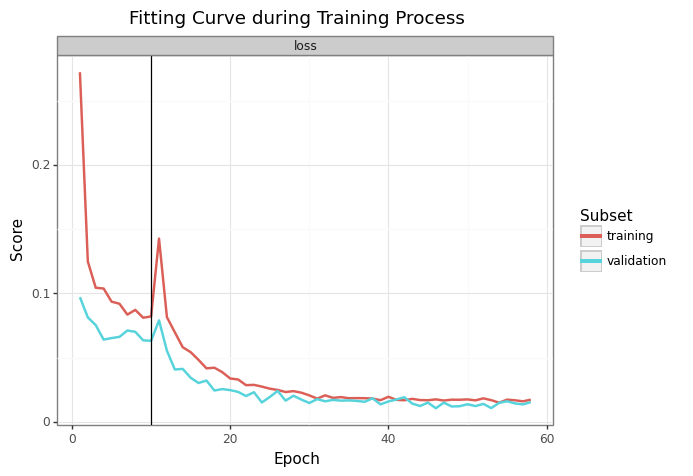

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: assets/07_ct-covid/out/img/plot.fitting_course.from_file.png


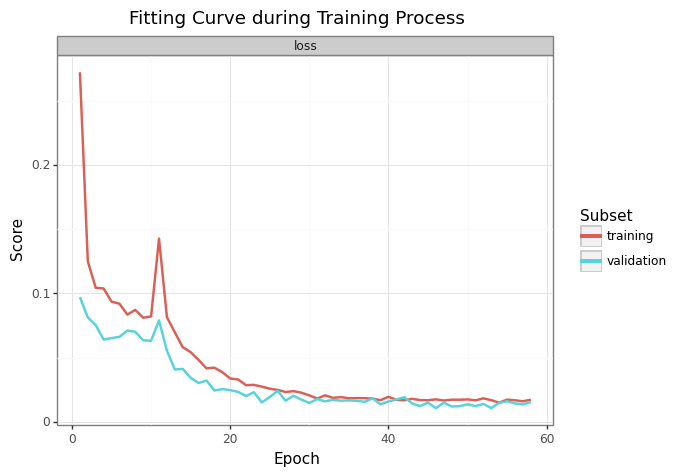

In [16]:
from aucmedi import evaluation
from aucmedi.utils.callbacks import *

# Option 1: From history dictionary (in-memory)
evaluation.fitting.evaluate_fitting(
    train_history=history,
    out_path=path_images,
    suffix='from_memory',
    show=True
)

# Option 2: From CSV
loaded_history = csv_to_history(path_history)
evaluation.fitting.evaluate_fitting(
    train_history=loaded_history,
    out_path=path_images,
    suffix='from_file',
    show=True
)

***

### Step 16: Evaluation

To evaluate our model's performance, we can use *AUCMEDI*'s `evaluation` module.

In [17]:
from aucmedi.evaluation import metrics

scores = metrics.compute_metrics(
    preds=predictions,
    labels=set_test[1],
    n_labels=n_classes
)

***

### Step 17: Visualization

In order for us to actually see the scores we achieved, we'll need some charts. In the `evaluation`, *AUCMEDI* also provides methods to visualize the results.

/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/performance.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 12 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: assets/07_ct-covid/out/img/plot.performance.barplot.png


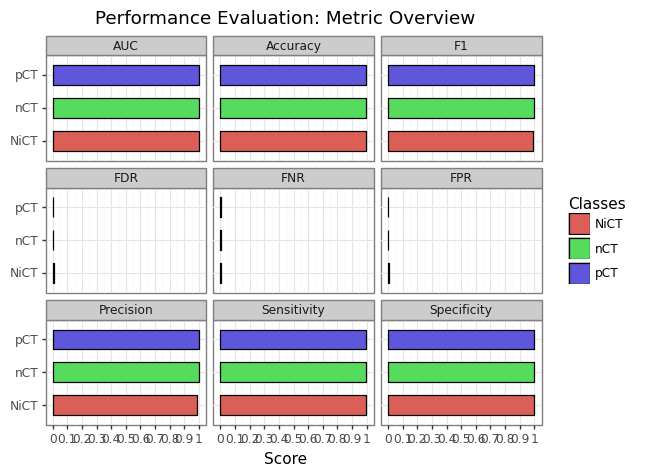

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: assets/07_ct-covid/out/img/plot.performance.confusion_matrix.png


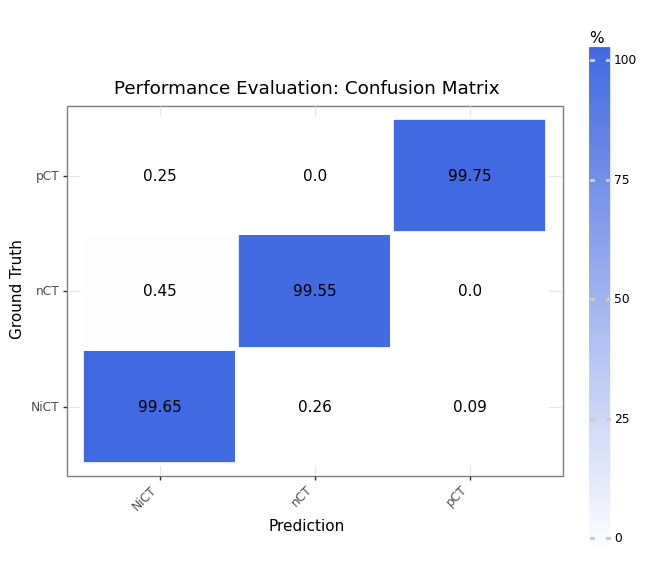

/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/performance.py:239: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: assets/07_ct-covid/out/img/plot.performance.roc.png


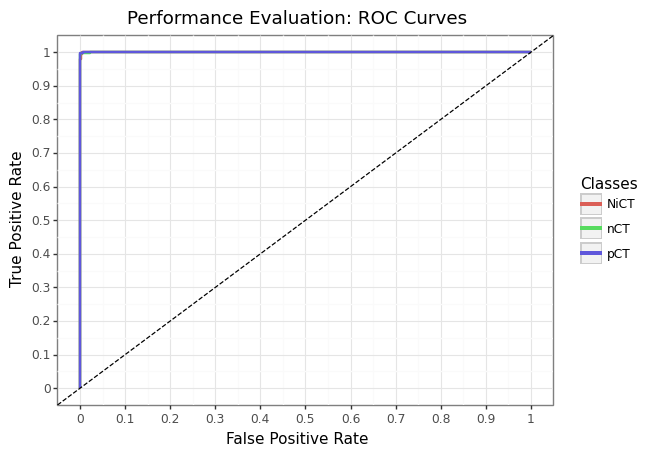

,metric,score,class
0,TP,1136.000000,NiCT
1,TN,2785.000000,NiCT
2,FP,11.000000,NiCT
3,FN,4.000000,NiCT
4,Sensitivity,0.996491,NiCT
5,Specificity,0.996066,NiCT
6,Precision,0.990410,NiCT
7,FPR,0.003934,NiCT
8,FNR,0.003509,NiCT
9,FDR,0.009590,NiCT


In [18]:
from aucmedi.evaluation import performance

performance.evaluate_performance(
    preds=predictions,
    labels=set_test[1],
    out_path=path_images,
    class_names=class_names,
    show=True,
    multi_label=is_multilabel
)

***

### Step 18: XAI

Understanding how a trained net decides, is invaluable. *AUCMEDI* comes with XAI functions, that can provide some insights. Please note: We have to build a separate `DataGenerator` and make an isolated prediction to calculate the Gradcam visualization.

In [19]:
from aucmedi.xai.decoder import xai_decoder

os.makedirs(path_xai, exist_ok=True)

# Multiclass: Find sample indices for each class
def find_relevant_indices():
    indices = {}
    occurring_masks, counts = np.unique(set_test[1], axis=0, return_counts=True)

    for mask_index, mask in enumerate(occurring_masks):
        key = np.flatnonzero(mask)
        filter = [sample_index for sample_index, sample in enumerate(set_test[1]) if (sample == mask).all()]
        indices[key[0]] = filter
    return indices

# XAI: Multilabel
def xai_multilabel():
    rdn = random.randint(0, len(set_test[1]) - 1)
    gen_xai_multilabel = data_generator.DataGenerator(
        samples=[set_test[0][rdn]], # Array containing one sample!
        labels=None,
        path_imagedir=path_input,
        image_format=image_format,
        data_aug=None,
        resize=model.meta_input,
        standardize_mode=model.meta_standardize,
        seed=seed
    )
    
    # Make and save predictions
    preds_xai_multilabel = model.predict(gen_xai_multilabel)
    columns = class_names
    preds_pd = pd.DataFrame(data=preds_xai_multilabel, columns=columns, index=[set_test[0][rdn]])
    preds_pd.to_csv(path_xai_predictions)
    
    xai_decoder(gen_xai_multilabel, model, preds=None, method="gradcam", out_path=path_xai)

# XAI: Multiclass
def xai_multiclass(): 
    relevant_indices = find_relevant_indices()
    chosen_samples = []
    for n in range(n_classes):
        if n not in relevant_indices:
            print('Could not find key {}. Must be empty.'.format(n))
        else:
            print('Found key {}! Belongs to class {}.'.format(n, class_names[n]))
            values = relevant_indices[n]
            rdn = random.randint(0, len(values) - 1)
            chosen = values[rdn]
            sample = set_test[0][chosen]
            chosen_samples.append(sample)
            
    gen_xai_multiclass = data_generator.DataGenerator(
        samples=chosen_samples,
        labels=None,
        path_imagedir=path_input,
        image_format=image_format,
        data_aug=None,
        resize=model.meta_input,
        standardize_mode=model.meta_standardize,
        seed=seed
    )
    
    # Make and save predictions
    preds_xai_multiclass = model.predict(gen_xai_multiclass)
    columns = [l for l in class_names if (project_name != 'dermatoscopy' or (project_name == 'dermatoscopy' and l != 'UNK'))]
    index = chosen_samples
    preds_pd = pd.DataFrame(data=preds_xai_multiclass, columns=columns, index=index)
    preds_pd.to_csv(path_xai_predictions)
        
    xai_decoder(gen_xai_multiclass, model, preds=preds_xai_multiclass, method="gradcam", out_path=path_xai)
    
xai_handler = {
    'multilabel': xai_multilabel,
    'multiclass': xai_multiclass
}

xai_handler['multilabel' if is_multilabel else 'multiclass']()
print('XAI images have been generated!')


Found key 0! Belongs to class NiCT.
Found key 1! Belongs to class nCT.
Found key 2! Belongs to class pCT.


/home/main/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


1/1 [==============================] - 1s 571ms/step
XAI images have been generated!
